In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
data = pd.read_csv('../data/processed_data.csv')
data['date'] = pd.to_datetime(data['date'])
# data.set_index('date', inplace=True)
data.head()

,date,wday,month,date_id,CASHBACK_STORE_1,CASHBACK_STORE_2,CASHBACK_STORE_3,item_id,store_id,cnt,sell_price,type_Cultural,type_National,type_Religious,type_Sporting,is_weekend
0,2011-01-29,1,1,1,0,0,0,STORE_2_085,STORE_2,3,1.00,0,0,0,0,1
1,2011-01-29,1,1,1,0,0,0,STORE_2_043,STORE_2,6,2.88,0,0,0,0,1
2,2011-01-29,1,1,1,0,0,0,STORE_2_054,STORE_2,6,2.28,0,0,0,0,1
3,2011-01-29,1,1,1,0,0,0,STORE_2_325,STORE_2,0,NaN,0,0,0,0,1
4,2011-01-29,1,1,1,0,0,0,STORE_2_090,STORE_2,108,1.25,0,0,0,0,1


In [3]:
store_id = 'STORE_2'
art = '_085'
art085=data[(data.item_id==store_id + art) & (data.store_id==store_id)]
art085.set_index('date', inplace=True)

In [4]:
num_days = 90
train = art085.iloc[:-num_days]
test = art085.iloc[-num_days:]

In [ ]:
import pmdarima as pm

# Автоматический подбор параметров SARIMA
smodel = pm.auto_arima(train['cnt'], 
                       seasonal=True, m=7, 
                       stepwise=True, suppress_warnings=True,
                       trace=True)

# Обучение модели SARIMA с подобранными параметрами
sarima_fit = smodel.fit(train['cnt'])

# Предсказание на тестовой выборке
forecast = sarima_fit.predict(n_periods=len(test))


In [6]:
mae = mean_absolute_error(test.cnt, forecast)
print(f'MAE: {mae}')
rmse = mean_squared_error(test.cnt, forecast)
print(f'RMSE: {rmse}')
# Построение графика
plt.figure(figsize=(12, 6))
# plt.plot(train.index, train['cnt'], label='Train')
plt.plot(test.index, test['cnt'], label='Test')
plt.plot(test.index, forecast, label='SARIMA Forecast')
plt.ylim(0, 15)
plt.legend()
plt.show()


NameError: name 'mean_absolute_error' is not defined

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error
from sktime.forecasting.base import ForecastingHorizon

df = art085
y_train, y_test = temporal_train_test_split(art085['cnt'], test_size=30)

# Создание горизонта предсказания
fh = ForecastingHorizon(y_test.index, is_relative=False)

# Определение и обучение модели auto_arima
forecaster = AutoARIMA(sp=7, seasonal=True, max_p=14, max_q=14)
forecaster.fit(y_train)

# Предсказание
y_pred = forecaster.predict(fh)


/home/ilgiz/dev/time-hub/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/ilgiz/dev/time-hub/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/ilgiz/dev/time-hub/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ilgiz/dev/time-hub/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ilgiz/dev/time-hub/venv/lib/python3

In [13]:
forecaster.get_fitted_params()

{'intercept': 1.7865179325134287e-05,
 'ar.L1': 1.052828288772063,
 'ar.L2': -0.1268296177813983,
 'ma.L1': -1.7791510342120922,
 'ma.L2': 0.7836579903369927,
 'ar.S.L7': 0.8969598618035953,
 'ar.S.L14': 0.012641954757480435,
 'ma.S.L7': -0.8825828948524563,
 'sigma2': 14.338534080523948,
 'order': (2, 1, 2),
 'seasonal_order': (2, 0, 1, 7),
 'aic': 9746.609699447063,
 'aicc': 9746.710936792395,
 'bic': 9796.009376048663,
 'hqic': 9764.851181009808}

MAE: 5.323716778779393
RMSE: 37.45541642574981


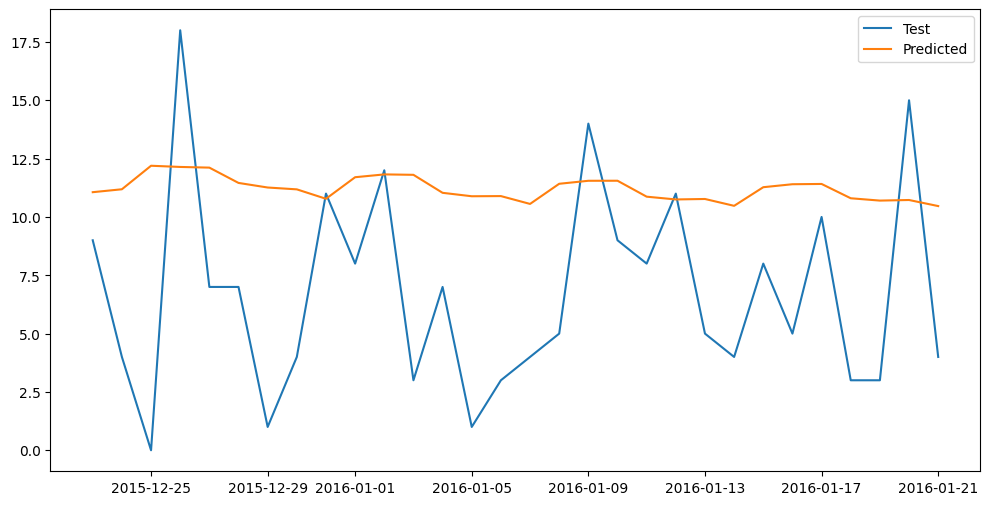

In [14]:
# Оценка качества модели
mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {mae}')
rmse = mean_squared_error(y_test, y_pred)
print(f'RMSE: {rmse}')

# Построение графика
plt.figure(figsize=(12, 6))
# plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

In [15]:
df = art085.copy()
print(len(df))
df['cnt_diff'] = df['cnt'].diff().dropna()

y_train, y_test = temporal_train_test_split(df['cnt_diff'].dropna(), test_size=90)

fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster = AutoARIMA(sp=7, seasonal=True, suppress_warnings=True)
forecaster.fit(y_train)

y_pred_diff = forecaster.predict(fh)

last_train_value = df['cnt'].iloc[-len(y_test)-1]
y_pred = y_pred_diff.cumsum() + last_train_value

mae = mean_absolute_error(y_test.cumsum() + last_train_value, y_pred)
print(f'MAE: {mae}')
rmse = mean_squared_error(y_test.cumsum() + last_train_value, y_pred)
print(f'RMSE: {rmse}')

1819
RMSE: 4.116886409061304
RMSE: 28.3923209144427


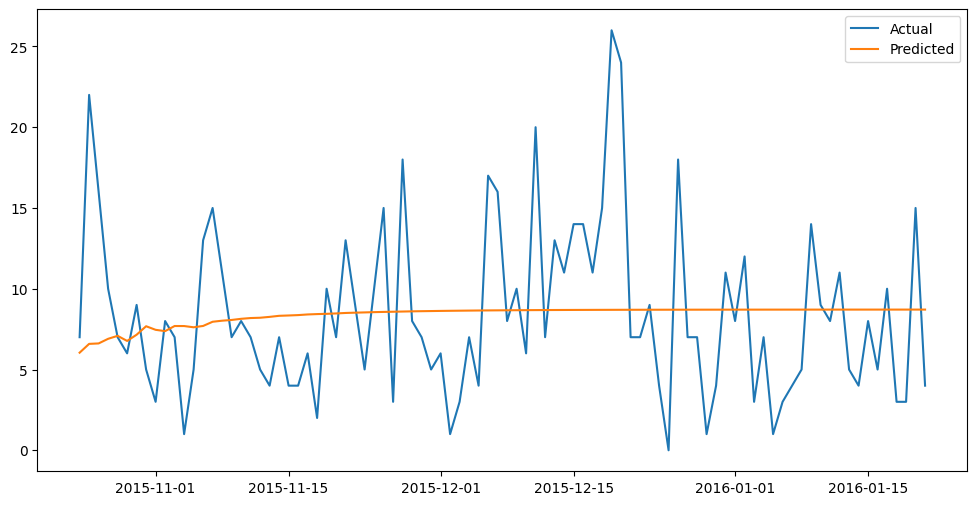

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.cumsum() + last_train_value, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()